In [89]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
from pymc import Binomial, Model, Gamma, Normal, sample, Beta
import sys

try:
    import bambi as bmb
except ImportError:
    !{sys.executable} -m pip install -q --upgrade bambi
    import bambi as bmb

In [63]:
ss = 100000
control_a = np.random.binomial(1,0.03, ss)
treatment_a = np.random.binomial(1,0.032, ss)
control_b = np.random.gamma(2,20, control_a.sum())
treatment_b = np.random.gamma(2.03,20, treatment_a.sum())
control_c = np.concatenate((np.zeros((ss - control_a.sum())), control_b))
treatment_c = np.concatenate((np.zeros((ss - treatment_a.sum())), treatment_b))

In [64]:
control_b.mean(), treatment_b.mean(), (treatment_b.mean() - control_b.mean()) / control_b.mean(), control_b.std(), treatment_b.std()

(39.782648731861414,
 40.39022815833971,
 0.015272472946018124,
 28.502647051176826,
 28.267830463334708)

In [65]:
control_c.mean(), treatment_c.mean(), (treatment_c.mean() - control_c.mean()) / control_c.mean(), control_c.std(), treatment_c.std()

(1.1676207402801329,
 1.2799663303377853,
 0.0962175355250188,
 8.302510081859966,
 8.68230120346778)

In [94]:
with Model() as model:  # model specifications in PyMC are wrapped in a with-statement
    # Define priors
    control_p = Beta("control_p", alpha=1, beta=1)
    treatment_p = Beta("treatment_p", alpha=1, beta=1)
    control_alpha =Normal("control_alpha",mu=2, sigma=0.2)
    control_beta = Normal("control_beta",mu=20, sigma=1)
    treatment_alpha = Normal("treatment_alpha",mu=2, sigma=0.2)
    treatment_beta = Normal("treatment_beta",mu=20, sigma=1)

    # Define likelihoods
    control_cvr_likelihood = Binomial("control_cvr_likelihood", n=ss, p=control_p, observed=control_a)
    treatment_cvr_likelihood = Binomial("treatment_cvr_likelihood", n=ss, p=treatment_p, observed=treatment_a)
    control_spent_likelihood = Gamma("control_spent_likelihood", alpha=control_alpha, beta=control_beta, observed=control_b)
    treatment_spent_likelihood = Gamma("treatment_spent_likelihood", alpha=treatment_alpha, beta=treatment_beta, observed=treatment_b)

    # Define parameters of interest
    pm.Deterministic("Difference in proportions", (treatment_p - control_p)/control_p)
    control_spent_mean = control_alpha / control_beta
    treatment_spent_mean = treatment_alpha / treatment_beta
    pm.Deterministic("Difference in spent", (treatment_spent_mean - control_spent_mean) / control_spent_mean)

    # Inference!
    # draw 3000 posterior samples using NUTS sampling
    idata = sample(1000)

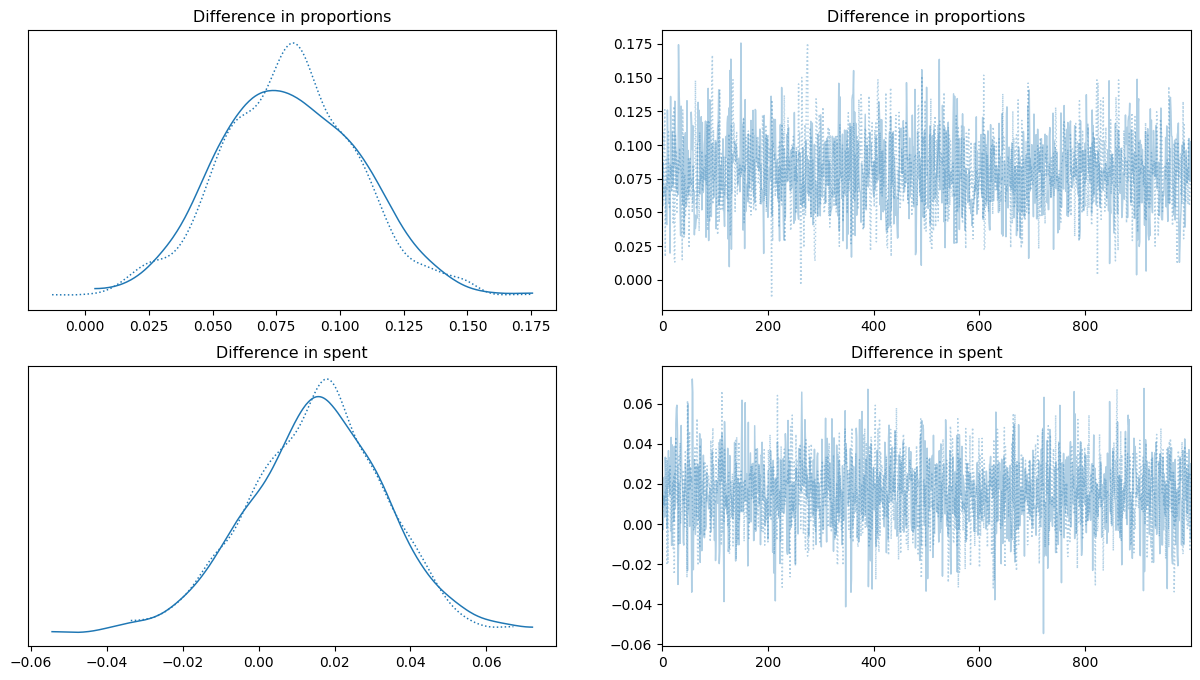

In [139]:
az.plot_trace(idata,var_names=["Difference in proportions", "Difference in spent"], figsize=(15, 8),);

In [132]:
chain_0 = idata.posterior["Difference in proportions"][0]
(np.array(chain_0) > 0).sum() / chain_0.shape[0]

1.0

In [134]:
chain_1 = idata.posterior["Difference in spent"][1]
(np.array(chain_1) > 0).sum() / chain_1.shape[0]

0.806